# Discretization


### 0. Backgroud: Why Discretization is Needed

In reinforcement learning, **model-free methods like [Monte Carlo (MC) control](../../discrete-problems/monte-carlo-methods/monte_carlo_blackjack.ipynb) and [Temporal-Difference (TD) control](../../discrete-problems/temporal-difference-methods/temporal_difference_blackjack.ipynb) perform efficiently in discrete state and action spaces**. This is because they can represent the state-action value function $ Q(s, a) $ using lookup tables or dictionaries, and optimization tasks (like updating policies) can be performed through simple enumeration. However, these methods face significant challenges when applied to continuous state or action spaces. For instance, in continuous state spaces, a Q-table would require an infinite number of rows to represent all possible states, making it infeasible. Similarly, in continuous action spaces, algorithms like Q-learning require computing the $\max_a Q(s', a)$ at each time step, which becomes a complex optimization problem instead of a straightforward comparison. **Therefore, to make reinforcement learning algorithms applicable to continuous spaces, we need to discretize these spaces, transforming continuous problems into discrete ones and enabling the use of existing algorithms.**

In this notebook, we will deal with continuous state and action spaces by discretizing them. This will enable us to apply reinforcement learning algorithms that are only designed to work with discrete spaces.

### 1. Import the Necessary Packages

In [3]:
import sys
import numpy as np
import gymnasium as gym
from collections import defaultdict

# for game rendering
import time
from PIL import Image
from IPython import display

# for plots
from plot_utils import visualize_samples, plot_scores, plot_q_table

# Set plotting options
%matplotlib inline
%config InlineBackend.figure_format='retina'
np.set_printoptions(precision=3, linewidth=120)

### 2. Explore Environment

<div style="text-align: center;">
    <img src="./images/mountain_car.gif" alt="Mountain Car Environment" width="50%">
</div>

We'll use [OpenAI Gym MountainCar-v0](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/mountain_car.py) environments to test and develop our algorithms. This environment have:

#### Continuous State Space

The observation is a `ndarray` with shape `(2,)` where the elements correspond to the following:

| Num  | Observation                          | Min   | Max  | Unit         |
| ---- | ------------------------------------ | ----- | ---- | ------------ |
| 0    | position of the car along the x-axis | -1.2  | 0.6  | position (m) |
| 1    | velocity of the car                  | -0.07 | 0.07 | velocity (v) |

#### Discrete Action Space

There are 3 discrete deterministic actions:

- 0: Accelerate to the left
- 1: Don’t accelerate
- 2: Accelerate to the right


#### Random Agent

In [4]:
# Create an environment and set random seed
env = gym.make('MountainCar-v0', render_mode="rgb_array")

Run the next code cell to watch a random agent.

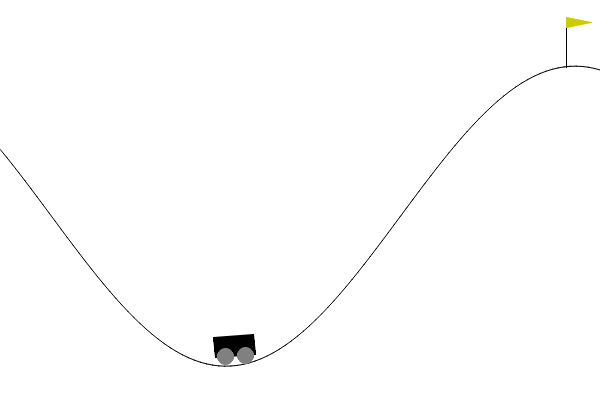

Final score: -200.0


In [5]:
state, info = env.reset(seed=42)
score = 0
for t in range(200):
    # clear frame
    display.clear_output(wait=True)

    action = env.action_space.sample()

    # render game
    frame = env.render()
    display.display(Image.fromarray(frame))
    time.sleep(0.05)

    state, reward, done, _, _ = env.step(action)
    score += reward
    if done:
        break

print('Final score:', score)
env.close()

Explore the state and action spaces, as well as sample them.

In [7]:
# Explore state (observation) space
print("State space:\n", env.observation_space)
print(" - low:", env.observation_space.low)
print(" - high:", env.observation_space.high)

# Explore the action space
print("Action space:\n", env.action_space)

print("-"*50)
# Generate some samples from the state space 
print("State space 10 samples:")
print(np.array([env.observation_space.sample() for i in range(10)]))

# Generate some samples from the action space
print("Action space 10 samples:")
print(np.array([env.action_space.sample() for i in range(10)]))

State space:
 Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
 - low: [-1.2  -0.07]
 - high: [0.6  0.07]
Action space:
 Discrete(3)
--------------------------------------------------
State space 10 samples:
[[-0.833  0.022]
 [-0.284  0.06 ]
 [-0.103 -0.037]
 [ 0.456  0.023]
 [-0.867 -0.033]
 [-0.52   0.016]
 [ 0.316 -0.016]
 [ 0.517  0.066]
 [ 0.014  0.014]
 [-0.565 -0.03 ]]
Action space 10 samples:
[2 1 0 0 0 0 2 0 1 2]


### 3. Discretilization

#### Create Discrete Grid

We will discretize the space using a uniformly-spaced grid. The following function created a grid, given the lower bounds (`low`), upper bounds (`high`), and number of desired `bins` along each dimension. It return the split points for each dimension, which will be 1 less than the number of bins.

For instance, if `low = [-1.0, -5.0]`, `high = [1.0, 5.0]`, and `bins = (10, 10)`, then your function should return the following list of 2 NumPy arrays:

<div style="text-align: center;">
    <img src="./images/uniform-discreate-method.png" alt="Mountain Car Environment" width="70%">
</div>


```
[array([-0.8, -0.6, -0.4, -0.2,  0.0,  0.2,  0.4,  0.6,  0.8]),
 array([-4.0, -3.0, -2.0, -1.0,  0.0,  1.0,  2.0,  3.0,  4.0])]
```

Note that the ends of `low` and `high` are **not** included in these split points. It is assumed that any value below the lowest split point maps to index `0` and any value above the highest split point maps to index `n-1`, where `n` is the number of bins along that dimension.

In [8]:
def create_uniform_grid(low, high, bins=(10, 10)):
    """Define a uniformly-spaced grid that can be used to discretize a space.
    
    Parameters
    ----------
    low : array_like
        Lower bounds for each dimension of the continuous space.
    high : array_like
        Upper bounds for each dimension of the continuous space.
    bins : tuple
        Number of bins along each corresponding dimension.
    
    Returns
    -------
    grid : list of array_like
        A list of arrays containing split points for each dimension.
    """
    grid = []
    low = np.array(low)
    high = np.array(high)
    for l, h, b in zip(low, high, bins):
        bin_width = (h - l) / b
        grid.append(l + bin_width * np.arange(1, b))
    return grid

low = [-1.0, -5.0]
high = [1.0, 5.0]
create_uniform_grid(low, high)  # [test]

[array([-0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8]),
 array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.])]

#### State Space From Continous to Discreate

Now write a function that can convert samples from a continuous space into its equivalent discretized representation, given a grid we created above. Use the [`numpy.digitize()`](https://docs.scipy.org/doc/numpy-1.9.3/reference/generated/numpy.digitize.html) function for this purpose.

Assume the grid is a list of NumPy arrays containing the following split points:
```
[array([-0.8, -0.6, -0.4, -0.2,  0.0,  0.2,  0.4,  0.6,  0.8]),
 array([-4.0, -3.0, -2.0, -1.0,  0.0,  1.0,  2.0,  3.0,  4.0])]
```

Here are some potential samples and their corresponding discretized representations:
```
[-1.0 , -5.0] => [0, 0]
[-0.81, -4.1] => [0, 0]
[-0.8 , -4.0] => [1, 1]
[-0.5 ,  0.0] => [2, 5]
[ 0.2 , -1.9] => [6, 3]
[ 0.8 ,  4.0] => [9, 9]
[ 0.81,  4.1] => [9, 9]
[ 1.0 ,  5.0] => [9, 9]
```

**Note**: There may be one-off differences in binning due to floating-point inaccuracies when samples are close to grid boundaries, but that is alright.

In [9]:
def discretize(sample, grid):
    """Discretize a sample as per given grid.
    
    Parameters
    ----------
    sample : array_like
        A single sample from the (original) continuous space.
    grid : list of array_like
        A list of arrays containing split points for each dimension.
    
    Returns
    -------
    discretized_sample : array_like
        A sequence of integers with the same number of dimensions as sample.
    """

    return [int(np.digitize(s, g))
            for s, g in zip(sample, grid)]

In [10]:
# Test with a simple grid and some samples
grid = create_uniform_grid([-1.0, -5.0], [1.0, 5.0])
samples = np.array(
    [[-1.0 , -5.0],
     [-0.81, -4.1],
     [-0.8 , -4.0],
     [-0.5 ,  0.0],
     [ 0.2 , -1.9],
     [ 0.8 ,  4.0],
     [ 0.81,  4.1],
     [ 1.0 ,  5.0]])

discretized_samples = np.array([discretize(sample, grid) for sample in samples])

for i, j in zip(samples, discretized_samples):
	print(f"{i} \t=> {j}")

[-1. -5.] 	=> [0 0]
[-0.81 -4.1 ] 	=> [0 0]
[-0.8 -4. ] 	=> [1 1]
[-0.5  0. ] 	=> [2 5]
[ 0.2 -1.9] 	=> [5 3]
[0.8 4. ] 	=> [9 9]
[0.81 4.1 ] 	=> [9 9]
[1. 5.] 	=> [9 9]


#### Visualization Discretized State Space

It might be helpful to visualize the original and discretized samples to get a sense of how much error we are introducing.

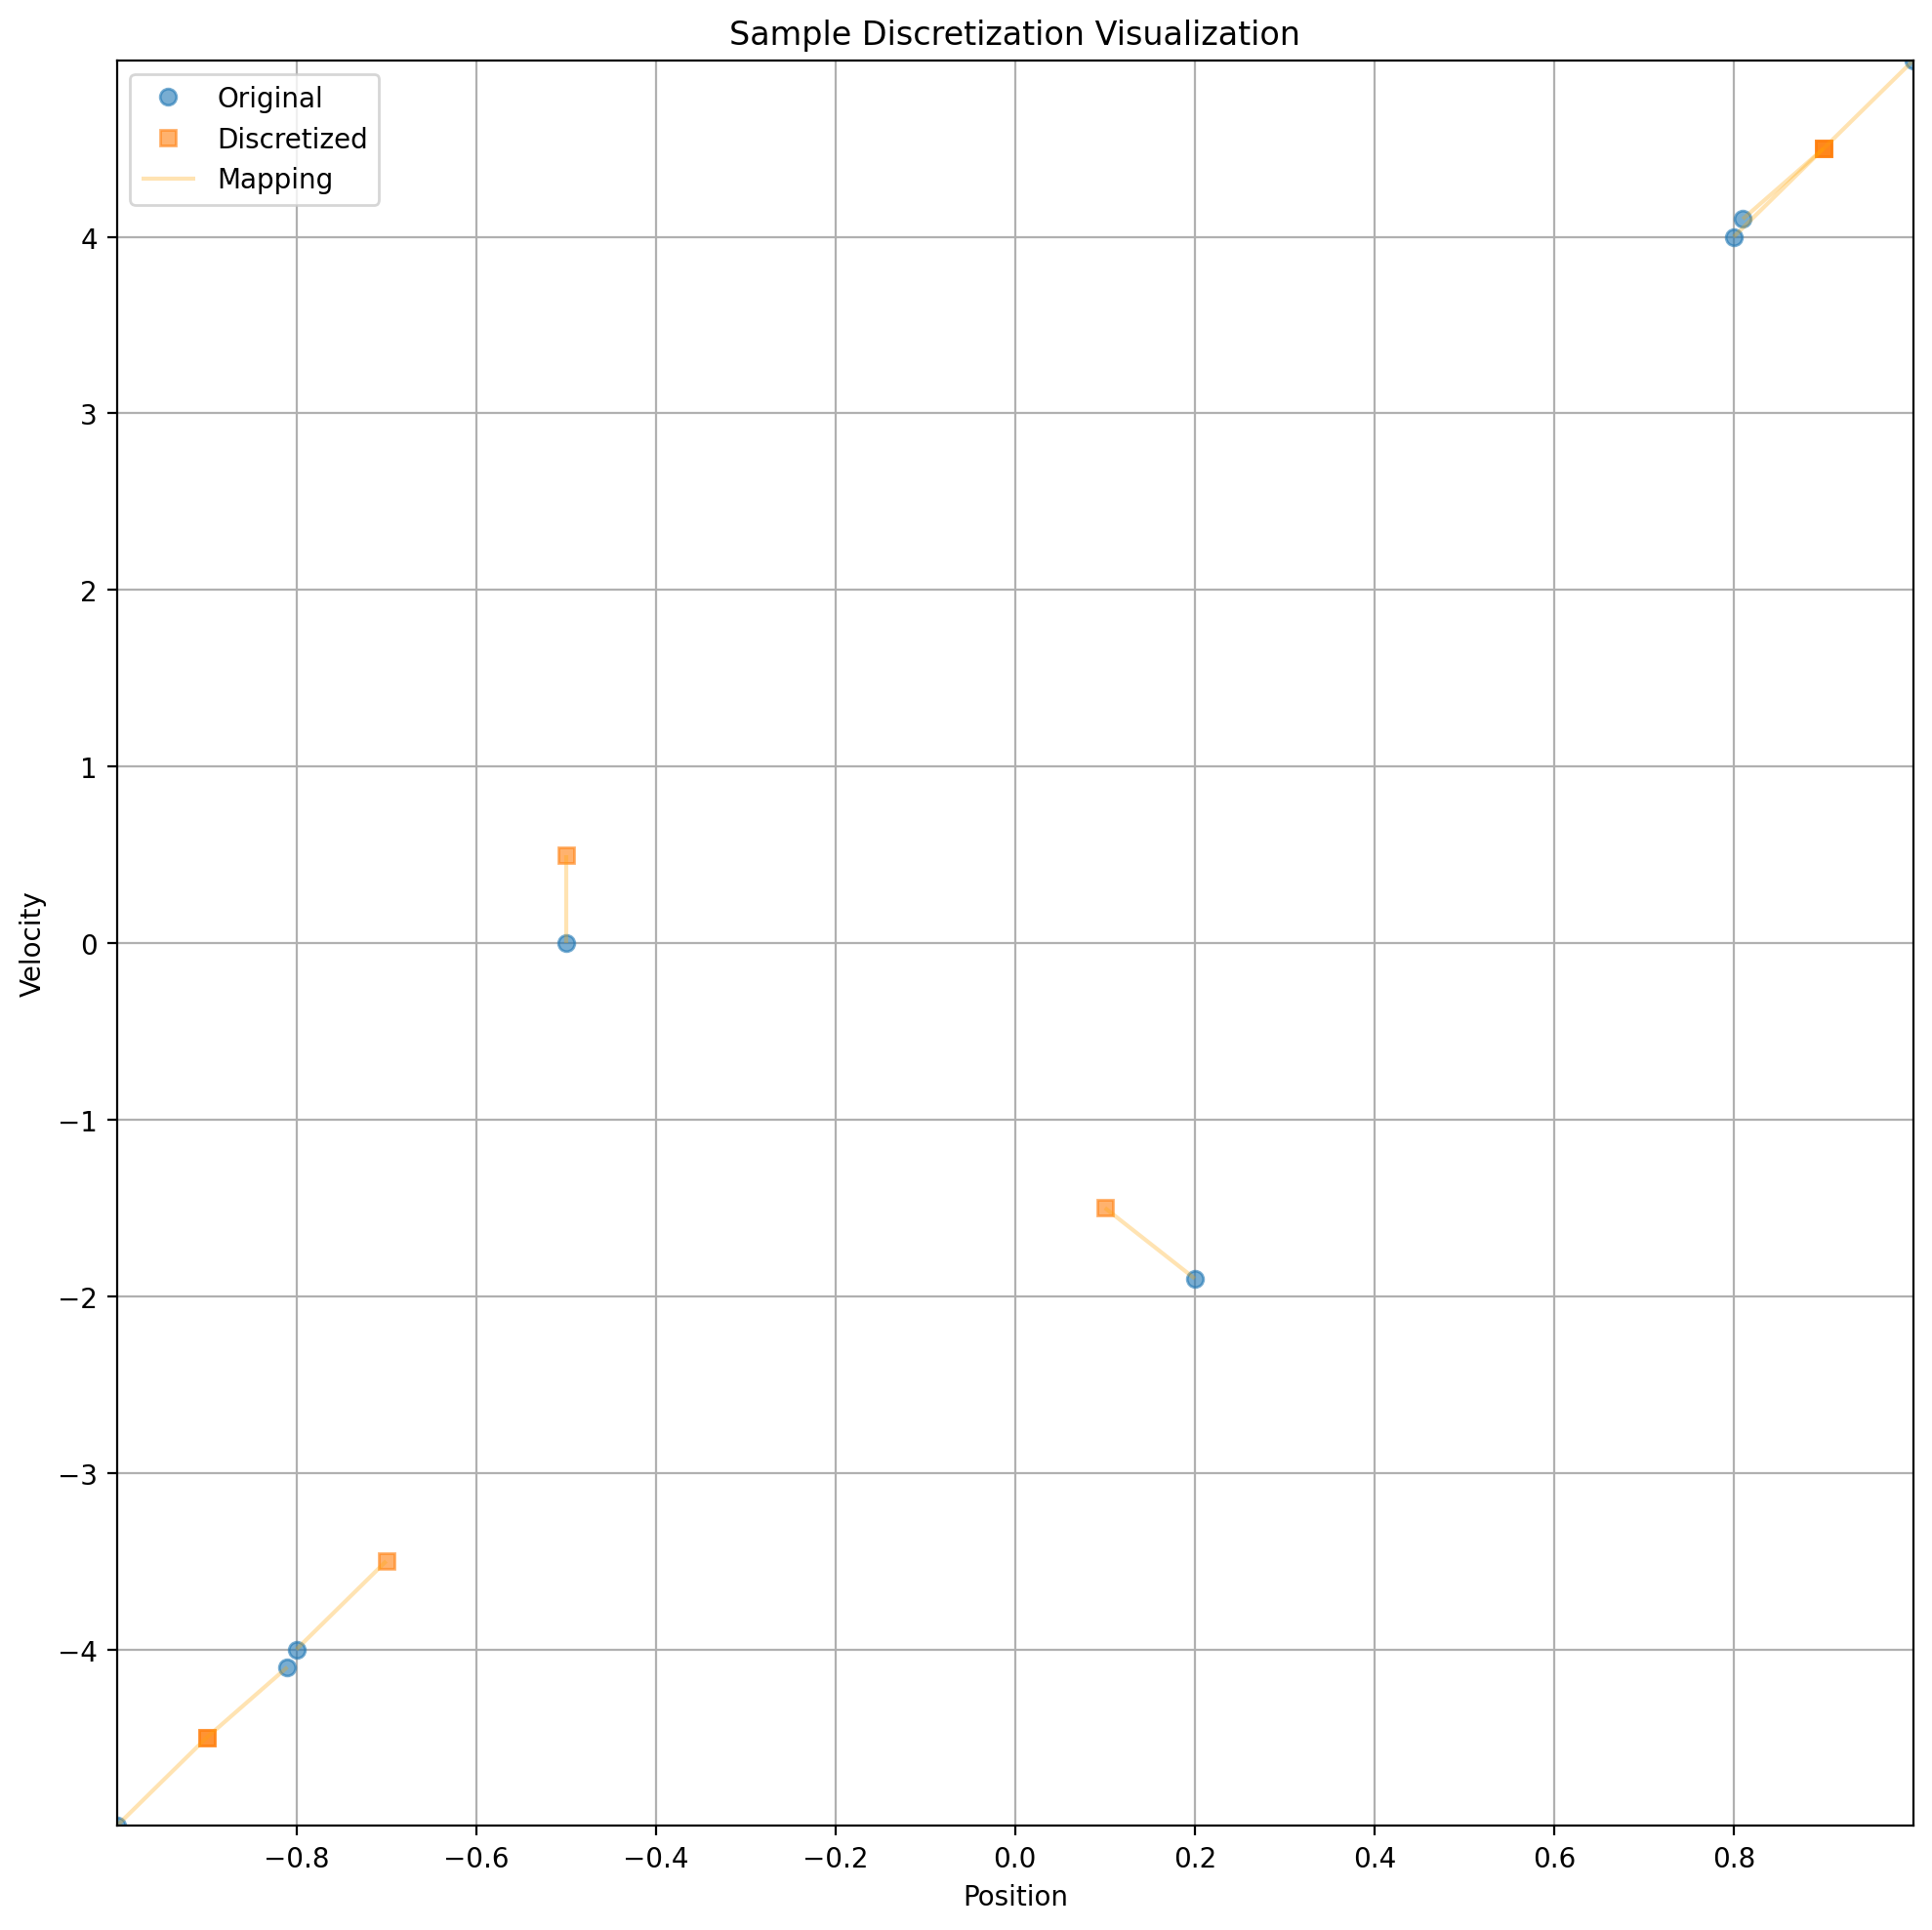

In [11]:
visualize_samples(samples, discretized_samples, grid, low, high)

Now that we have a way to discretize a state space, let's apply it to our reinforcement learning environment.

In [12]:
# Create a grid to discretize the state space
state_grid = create_uniform_grid(env.observation_space.low, env.observation_space.high, bins=(10, 10))
state_grid

[array([-1.02, -0.84, -0.66, -0.48, -0.3 , -0.12,  0.06,  0.24,  0.42]),
 array([-5.600e-02, -4.200e-02, -2.800e-02, -1.400e-02,  1.863e-09,  1.400e-02,  2.800e-02,  4.200e-02,  5.600e-02])]

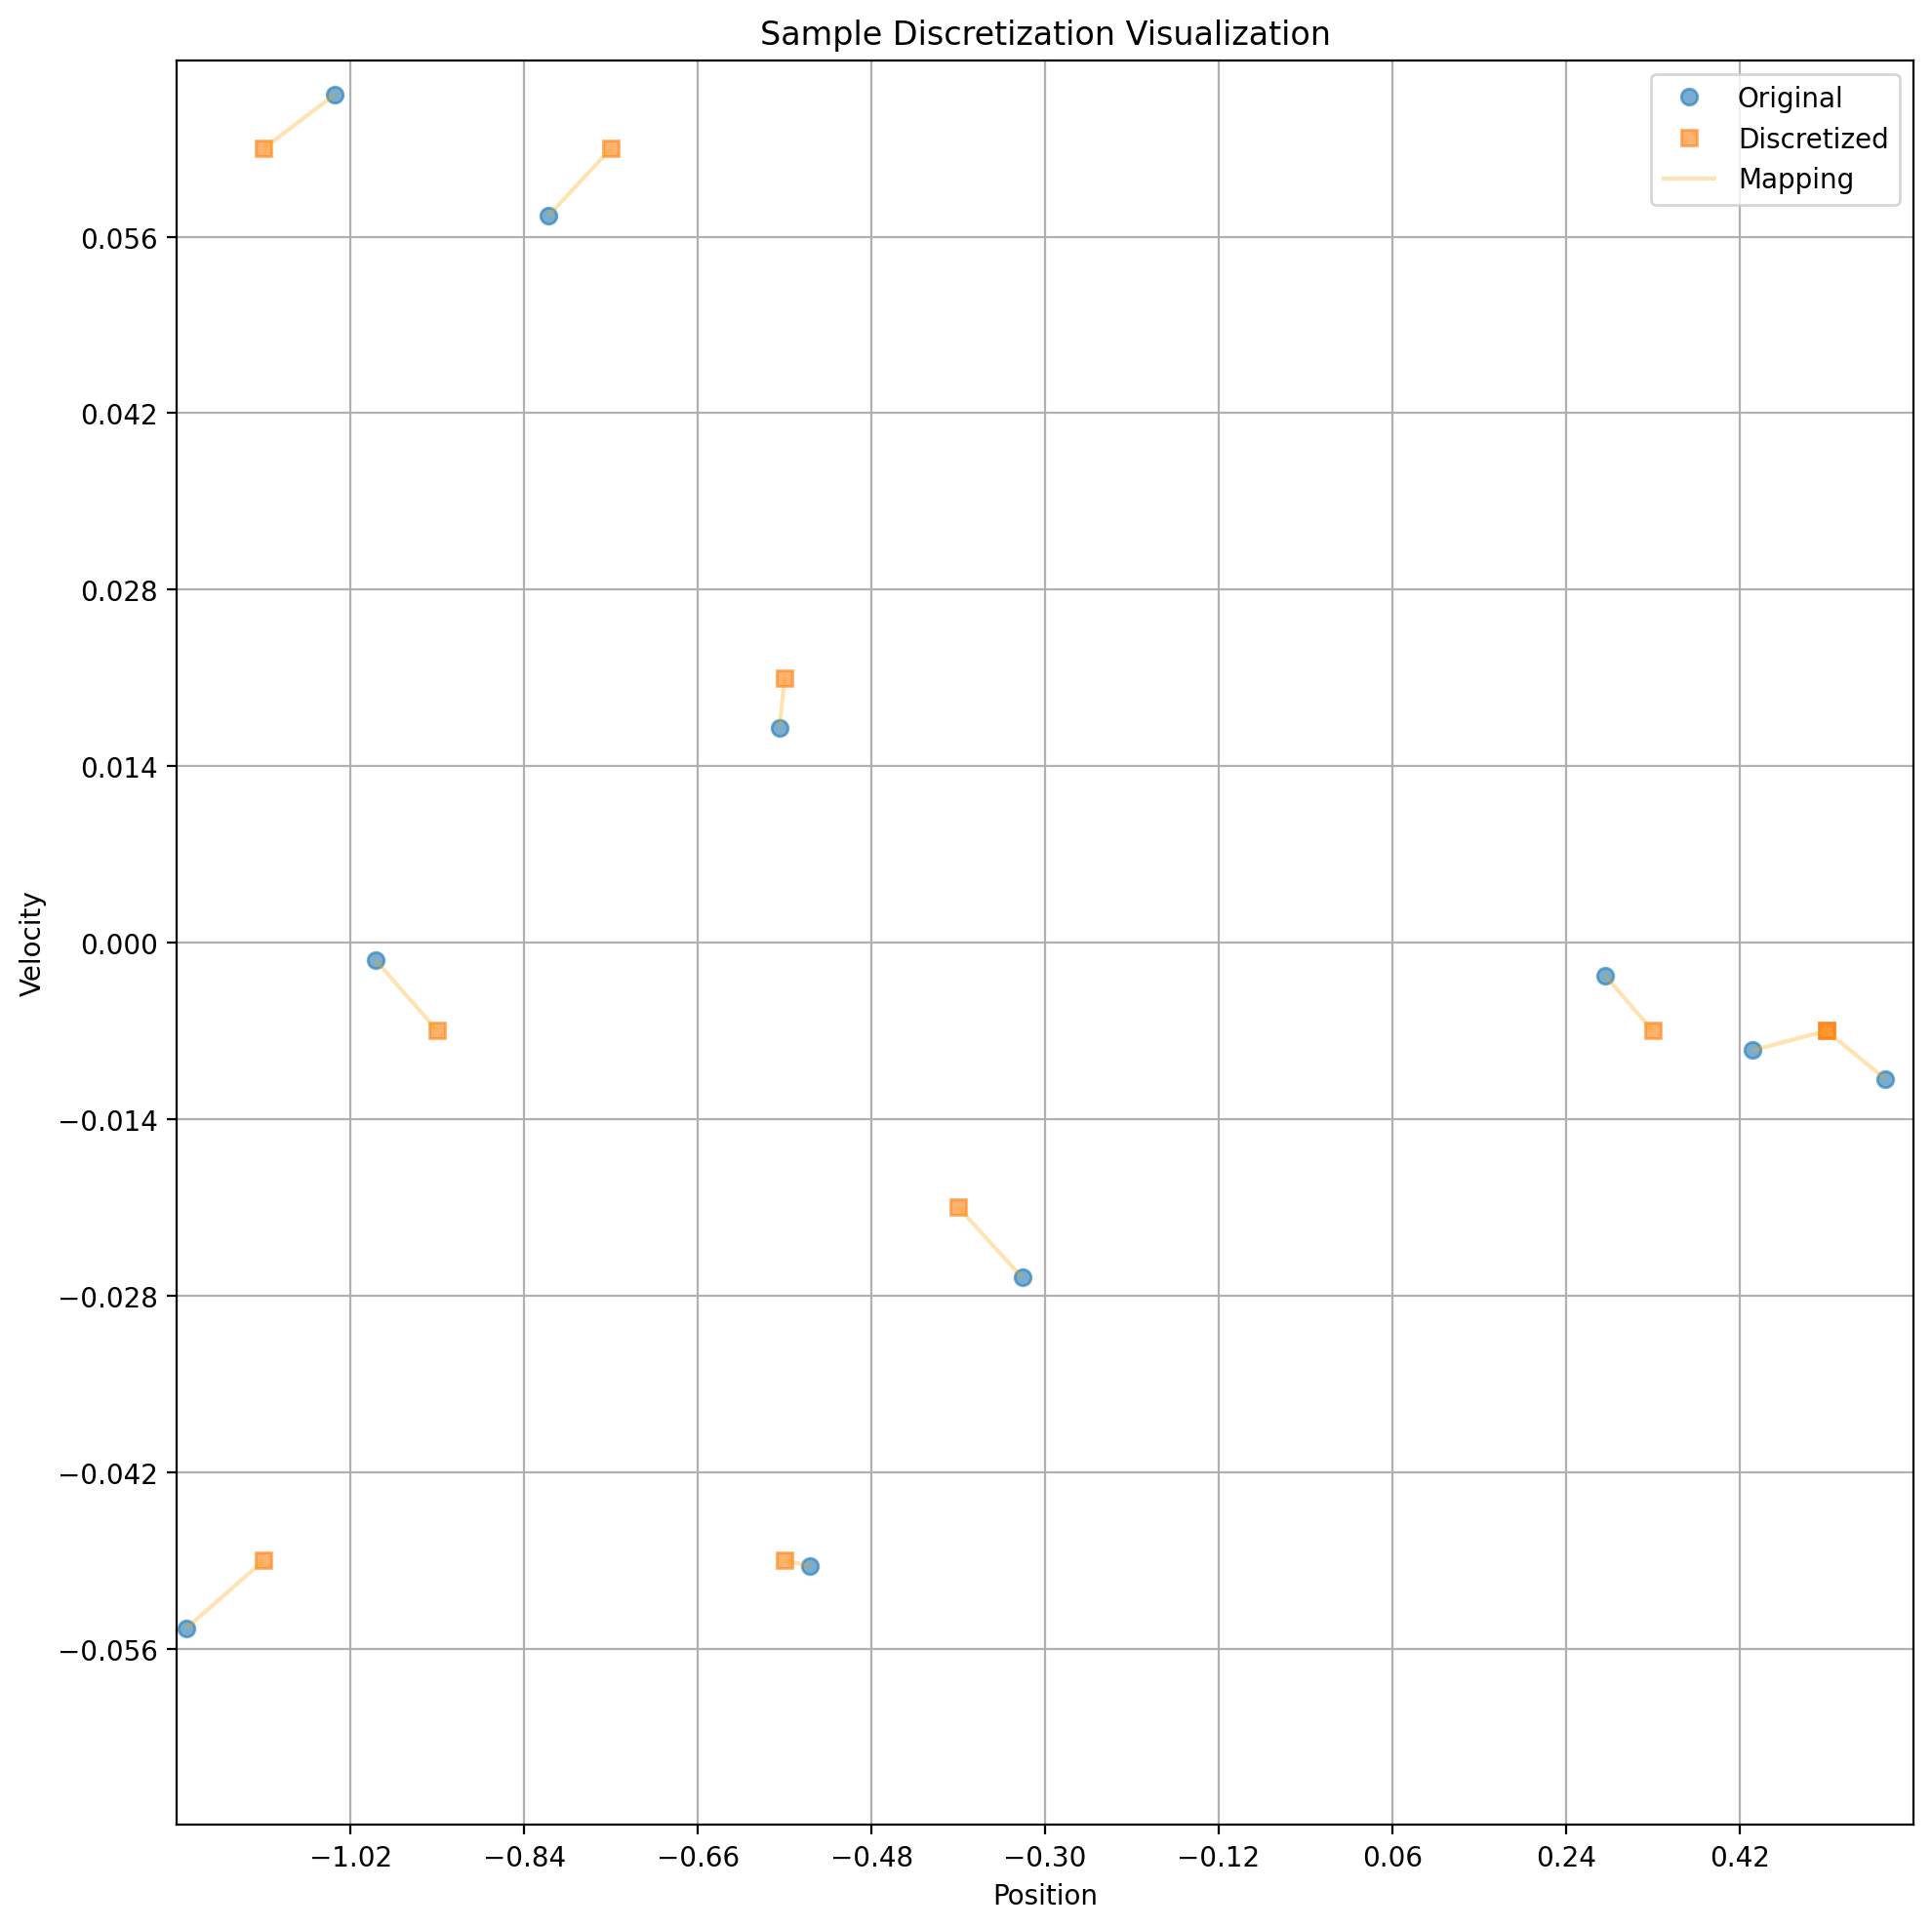

In [16]:
# Obtain some samples from the space, discretize them, and then visualize them
state_samples = np.array(
	[env.observation_space.sample() for i in range(10)]
)

discretized_state_samples = np.array(
    [discretize(sample, state_grid) for sample in state_samples]
)

visualize_samples(
    state_samples,
    discretized_state_samples,
    state_grid,
    env.observation_space.low,
    env.observation_space.high,
)

If we have enough bins, the discretization doesn't introduce too much error into your representation.

### 5. Q-Learning (or SARSA Max)

Provided below is a simple Q-Learning agent.

In [18]:
class QLearningAgent:

    def __init__(
        self,
        state_grid,
        nA=3,
        epsilon=1.0,
        alpha=0.02,
        gamma=0.99,
        eps_decay=0.9995,
        eps_min=0.01,
        seed=505,
    ):
        """Initialize agent.

        Params
        ======
        - state_grid: discretized state space
        - nA: number of actions available to the agent

        """
        self.seed = np.random.seed(seed)
        self.nA = nA
        self.state_grid = state_grid

        # Create Q-table
        self.Q = defaultdict(lambda: np.zeros(self.nA))

        # Learning parameters
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.epsilon = epsilon  # initial exploration rate
        self.eps_decay = eps_decay  # how quickly should we decrease epsilon
        self.eps_min = eps_min

    def __repr__(self):
        return (
            f"State space size: {tuple(len(splits) + 1 for splits in self.state_grid)}\n"
            f"Action space size: {self.nA}"
        )

    def preprocess_state(self, state):
        """Map a continuous state to its discretized representation."""
        return tuple(discretize(state, self.state_grid))

    def select_action(self, state):
        """Given the state, select an action.

        Params
        ======
        - state: the current state of the environment

        Returns
        =======
        - action: an integer, compatible with the task's action space
        """
        state = self.preprocess_state(state)

        self.epsilon *= self.eps_decay
        self.epsilon = max(self.epsilon, self.eps_min)

        do_exploration = np.random.random() < self.epsilon
        if do_exploration:
            return np.random.choice(np.arange(self.nA))
        else:
            return np.argmax(self.Q[state])

    def step(self, state, action, reward, next_state, done, mode="train"):
        """Update the agent's knowledge, using the most recently sampled tuple.

        Params
        ======
        - state: the previous state of the environment
        - action: the agent's previous choice of action
        - reward: last reward received
        - next_state: the current state of the environment
        - done: whether the episode is complete (True or False)
        """
        state = self.preprocess_state(state)

        if mode == "test":
            # Test mode: Simply produce an action
            return np.argmax(self.Q[state])
        else:
            next_state = self.preprocess_state(next_state)
            if done:
                self.Q[state][action] = self.Q[state][action] + self.alpha * (
                    reward - self.Q[state][action]
                )
            else:
                G_estimate = reward + self.gamma * np.max(self.Q[next_state])
                self.Q[state][action] = self.Q[state][action] + self.alpha * (
                    G_estimate - self.Q[state][action]
                )


def interact(env, agent, num_episodes=20000, window=100, mode="train"):
    """Monitor agent's performance.

    Params
    ======
    - env: instance of OpenAI Gym's(maintained by gymnasium) mountain car environment
    - agent: instance of class Agent (see Agent.py for details)
    - num_episodes: number of episodes of agent-environment interaction
    - window: number of episodes to consider when calculating average rewards

    Returns
    =======
    - scores: list containing average rewards
    - max_avg_score: largest value in the scores list
    """

    # initialize best average reward
    max_avg_score = -np.inf

    # initialize monitor for most recent rewards
    scores = []

    # for each episode
    for i_episode in range(1, num_episodes + 1):
        # begin the episode
        state, _ = env.reset()

        # initialize the sampled reward
        total_reward = 0
        while True:
            # agent selects an action
            action = agent.select_action(state)

            # agent performs the selected action
            next_state, reward, done, _, _ = env.step(action)

            # agent performs internal updates based on sampled experience
            agent.step(state, action, reward, next_state, done)

            # update the sampled reward
            total_reward += reward

            # update the state (s <- s') to next time step
            state = next_state

            if done:
                # save final sampled reward
                scores.append(total_reward)
                break

        if mode == "train":
            # Print episode stats
            if len(scores) > window:
                avg_score = np.mean(scores[-window:])
                if avg_score > max_avg_score:
                    max_avg_score = avg_score

            if i_episode % window == 0:
                print(
                    "\rEpisode {}/{} | Max Average Score: {}".format(
                        i_episode, num_episodes, max_avg_score
                    ),
                    end="",
                )
                sys.stdout.flush()

            if i_episode == num_episodes:
                print("\n")
    return scores


agent = QLearningAgent(
    state_grid,
    nA=env.action_space.n,
    epsilon=1.0,
    alpha=0.02,
    gamma=0.99,
    eps_decay=0.9995,
    eps_min=0.01,
    seed=505,
)
agent

State space size: (10, 10)
Action space size: 3

#### Training

In [19]:
scores = interact(env, agent, num_episodes=20000, window=100, mode='train')

Episode 20000/20000 | Max Average Score: -119.36



#### Visualize Learning curve

The best way to analyze if agent was learning the task is to plot the scores. It should generally increase as the agent goes through more episodes.

If scores are noisy, it might be difficult to tell whether agent is actually learning. To find the underlying trend, we also want to plot a rolling mean of the scores.

As below figure showed, the mean episode scores go up over time.

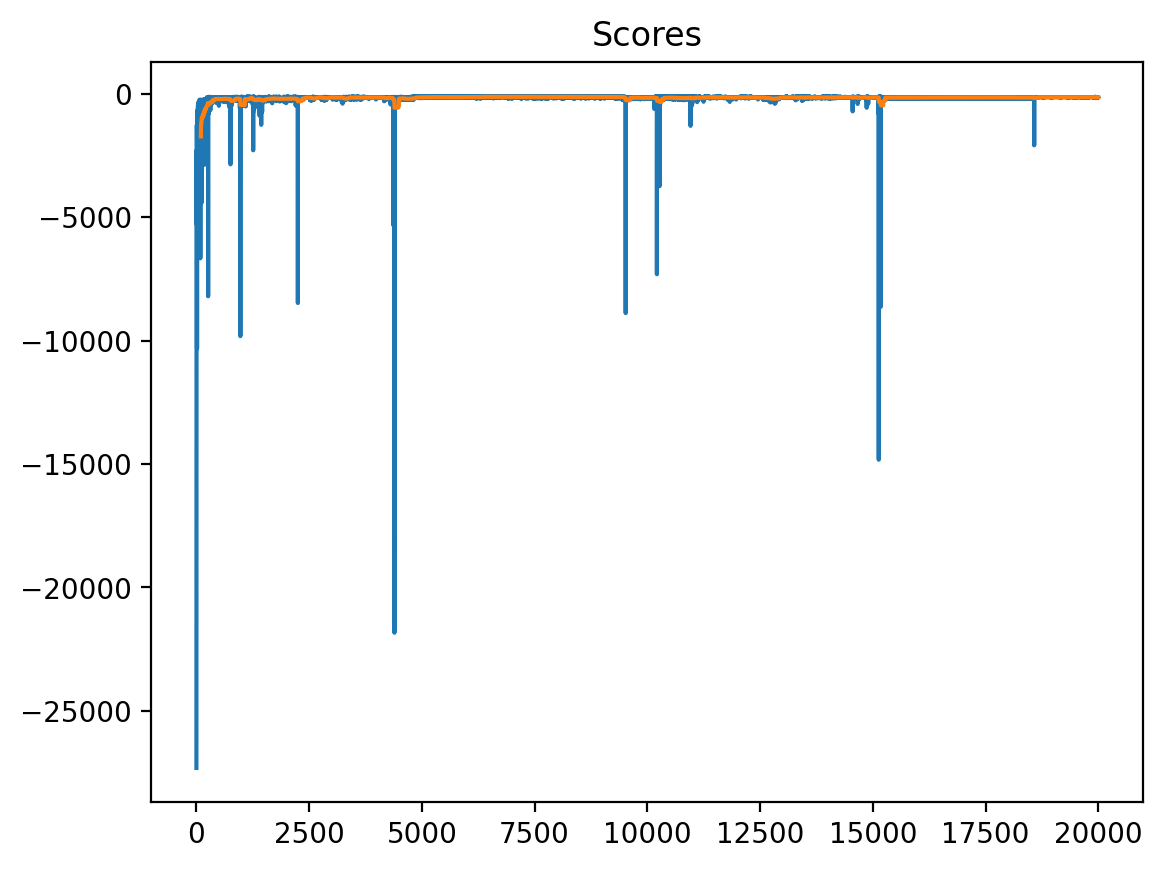

In [20]:
rolling_mean = plot_scores(scores)

#### Testing

Next, we freeze the agent and run the agent in test mode to see how well it performs.

Test Completed on 100 episodes with avg. score = -137.41


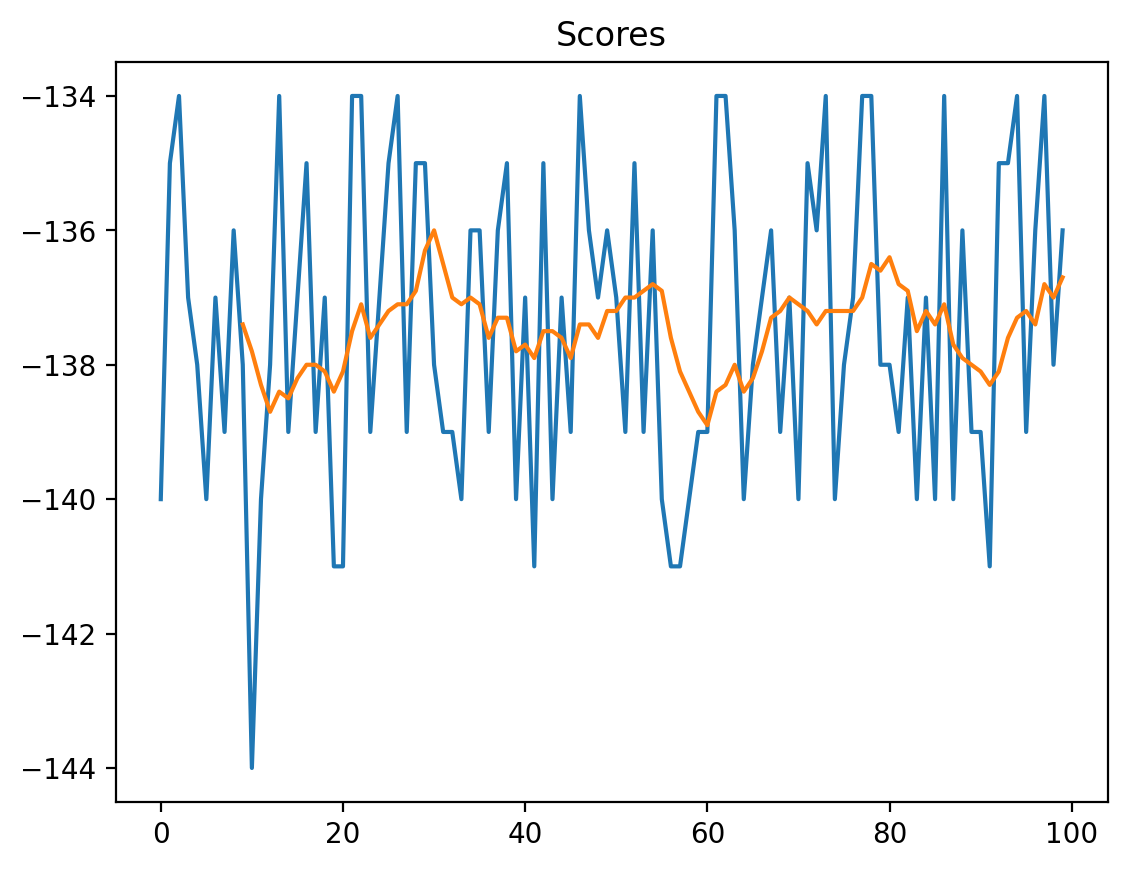

In [21]:
# Run in test mode and analyze scores obtained
test_scores = interact(env, agent, num_episodes=100, mode="test")
print(
    f"Test Completed on {len(test_scores)} episodes with avg. score = {np.mean(test_scores)}"
)
_ = plot_scores(test_scores, rolling_window=10)

#### Visualize Q table

It's also interesting to look at the final Q-table that is learned by the agent. Note that the Q-table is a dict of size MxNxA, where each key is a tuple, such as (M, N), and value is np.array with size of A. We are interested in the maximum Q-value for each state (which is state value matrix), and the corresponding (best) action associated with that value.

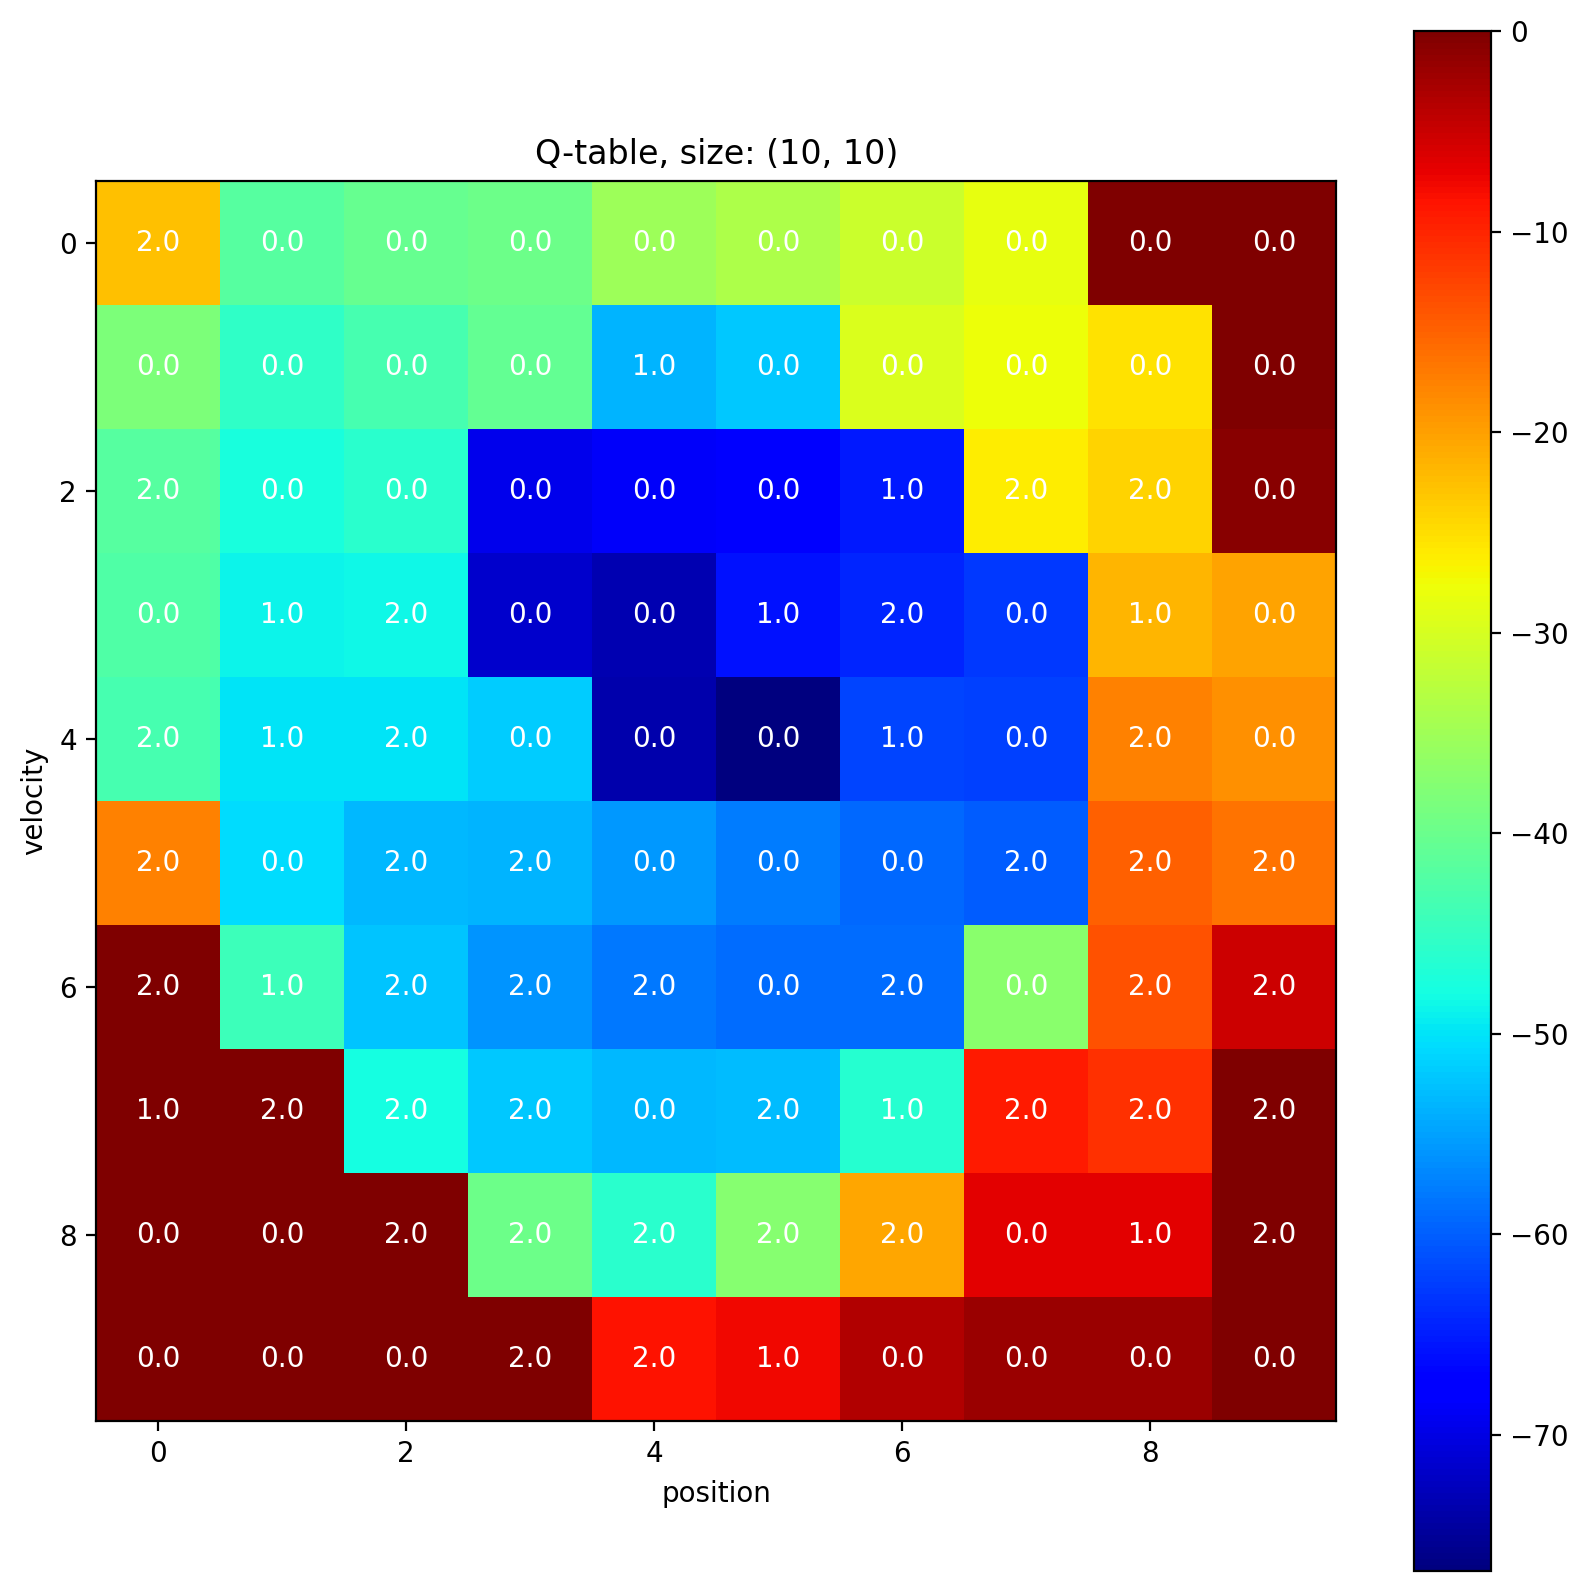

In [22]:
plot_q_table(agent.Q, state_grid)

### 6. Modify the Grid

Now we use a finer grid, with more bins per dimension, at the cost of higher model complexity (more parameters to learn).

In [23]:
# Create a new agent with a different state space grid
state_grid_finer = create_uniform_grid(
    env.observation_space.low,
    env.observation_space.high, 
    bins=(20, 20)
)
agent_finer = QLearningAgent(
    state_grid_finer,
    nA=env.action_space.n,
    epsilon=1.0,
    alpha=0.02,
    gamma=0.99,
    eps_decay=0.9995,
    eps_min=0.01,
    seed=505,
)

# initialize a list to store scores for this agent
agent_finer.scores = []  

Episode 50000/50000 | Max Average Score: -116.33



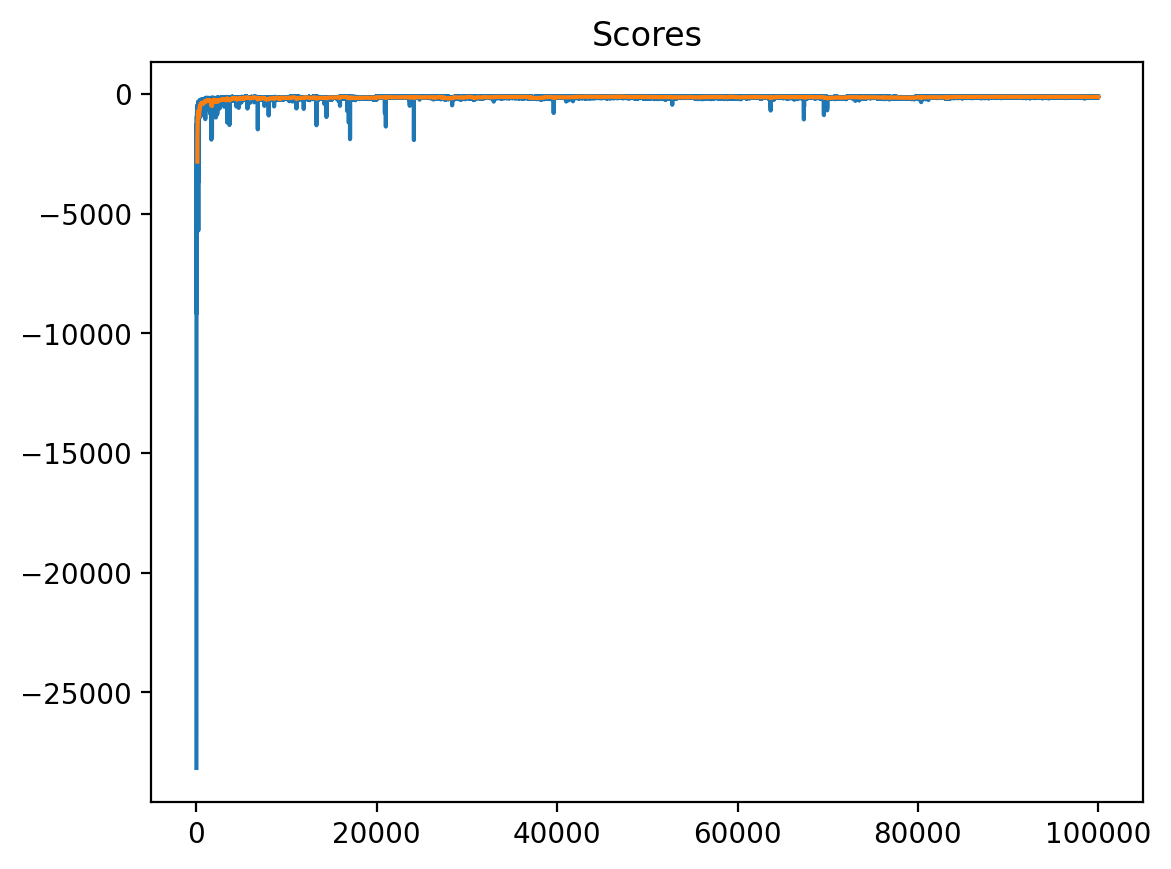

In [25]:
# Train it over a desired number of episodes and analyze scores
# Note: This cell can be run multiple times, and scores will get accumulated

# accumulate scores
agent_finer.scores += interact(env, agent_finer, num_episodes=50000)

rolling_mean_finer = plot_scores(agent_finer.scores)

Test Completed 100 episodes with avg. score = -122.12


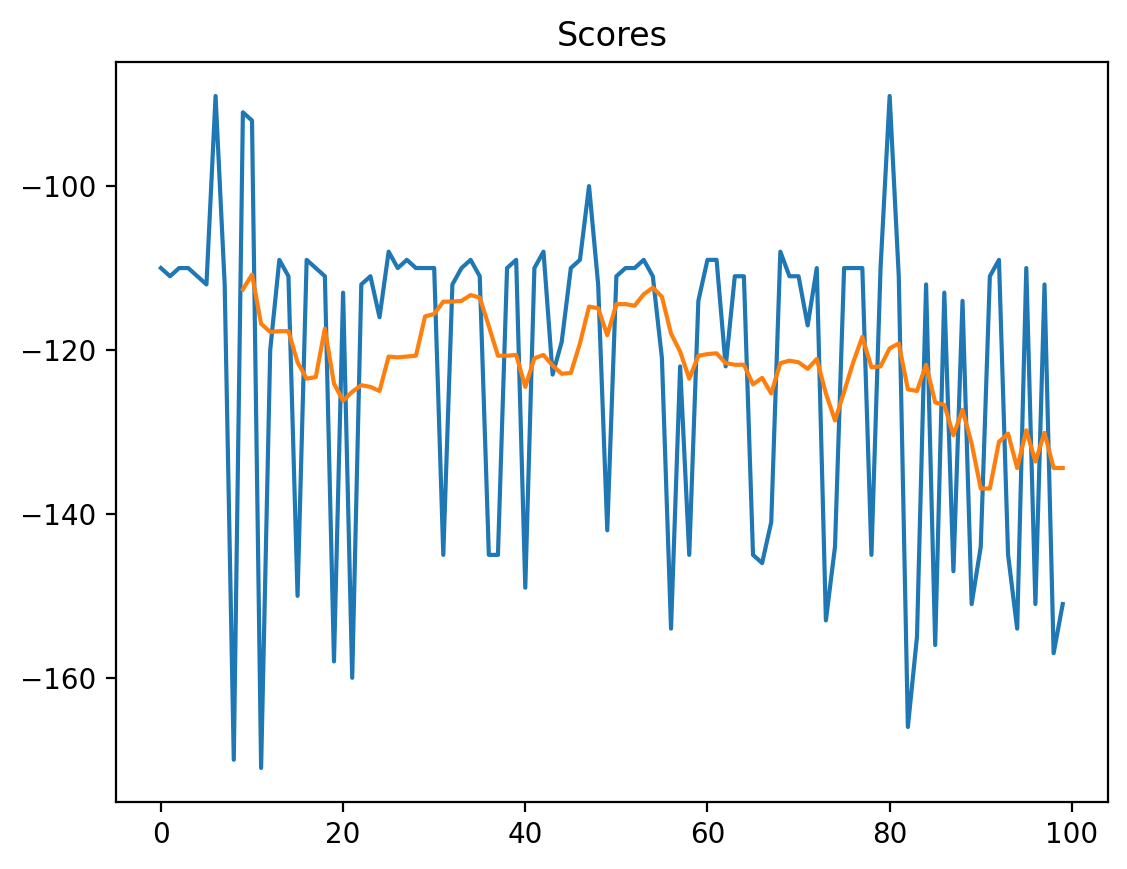

In [27]:
# Run in test mode and analyze scores obtained
test_scores = interact(env, agent_finer, num_episodes=100, mode='test')
print(
	f"Test Completed {len(test_scores)} episodes with avg. score = {np.mean(test_scores)}"
)
_ = plot_scores(test_scores, rolling_window=10)

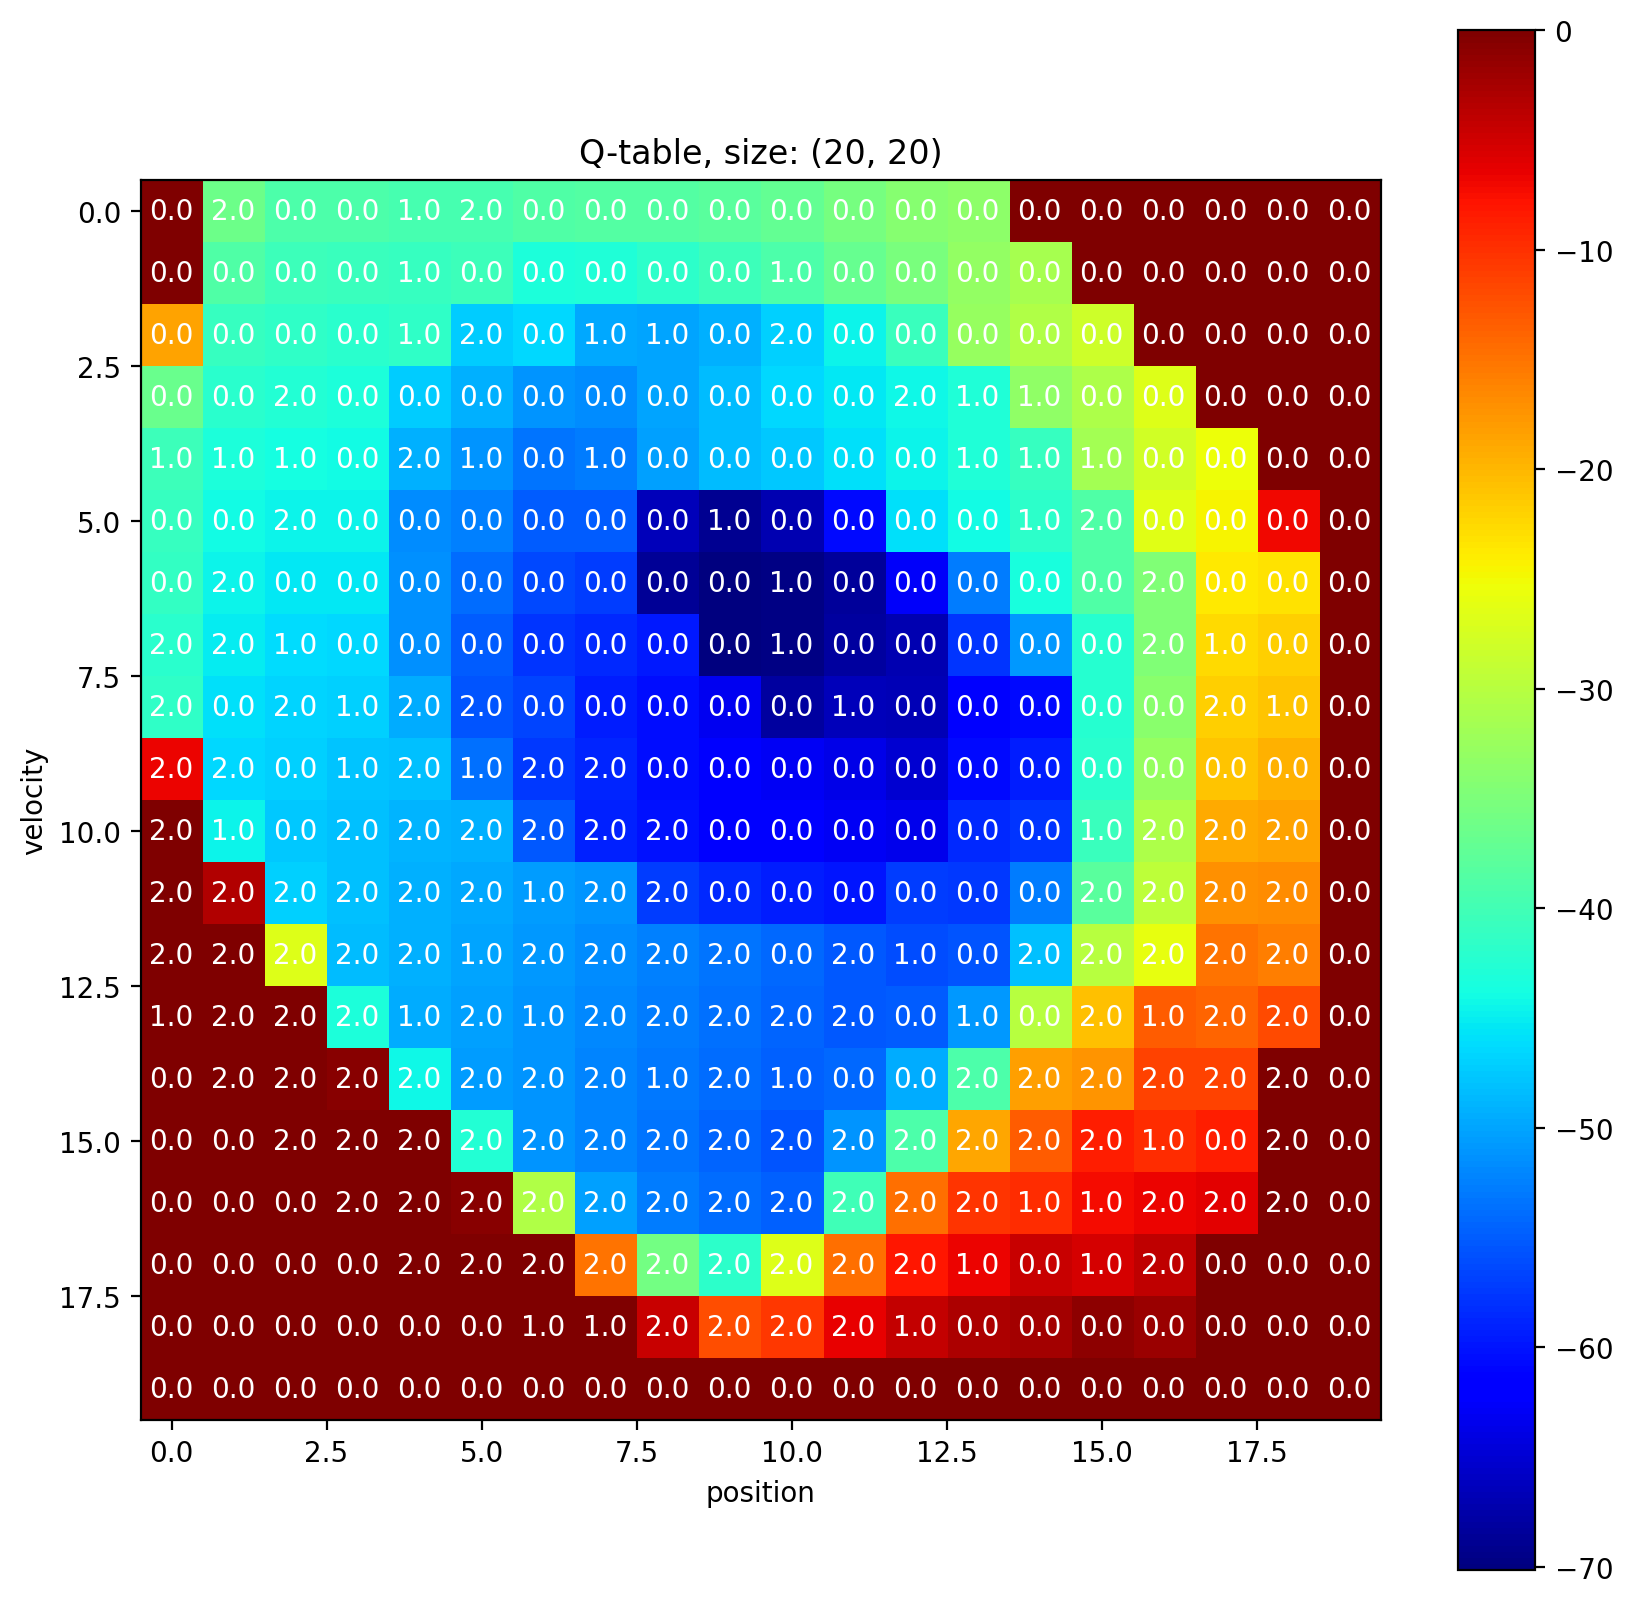

In [28]:
plot_q_table(agent_finer.Q, state_grid_finer)

### 7. Watch a Smart Agent

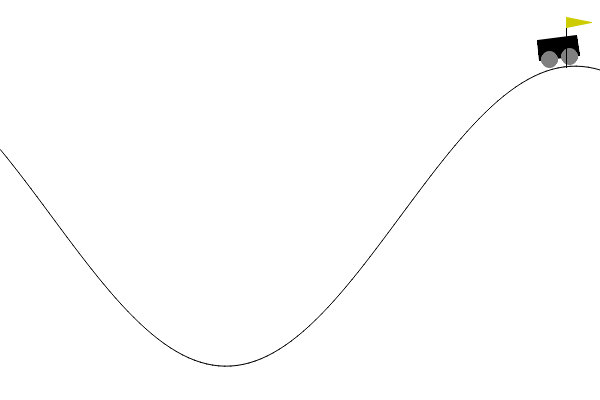

Final score: -145.0


In [29]:
state, info = env.reset(seed=42)
score = 0
for t in range(200):
    # clear frame
    display.clear_output(wait=True)

    action = agent_finer.step(state, None, None, None, None, mode='test')

    # render game
    frame = env.render()
    display.display(Image.fromarray(frame))
    time.sleep(0.05)

    state, reward, done, _, _ = env.step(action)
    score += reward
    if done:
        break

print('Final score:', score)
env.close()